# Lab05 - Vegetation Indices & KNN pixel classification

Goals of the lecture:
1. Apply different Vegetation Indices to multispectral satellite images (NDVI, NBR, NDSI)
2. Conduct pixel-based classification on a hyperspectral image with a k-Nearest Neighbor (k-NN) classifier
3. Evaluate the performance of the k-NN classifier 

# Part I: Vegetation Indices

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Downloading Sentinel-2 image

For convenience, we provide 11 bands of a 13-bands sentinel-2 patch. All bands are provided in a spatial resolution of 60mx60m to simplify index analysis and visualization (some bands were downscaled). The conversion to float32 and clipping have already been performed. The original band resolution can be seen below. **Please note**: in operational scenarios the lower resolution bands are usually upscaled to meet the spatial resolution of the 10mx10m bands. 

<img src="https://docs.kai-tub.tech/ben-docs/_images/ben_bands_vis.png" align="center" alt="Drawing" style="width: 900px;height:470px"/>

Source: https://docs.kai-tub.tech/ben-docs/_images/ben_bands_vis.png

Band Legend:
- B04 is Red, B03 is Green, B02 is Blue
- B05, B06, B07, B8A relate to VNIR (Visible Near Infrared)
- B11, B12 relate to SWIR (Short Wave Infrared)
- B01 band for Aerosols - _not needed in this lab_
- B09 band for Water Vapor - _not needed in this lab_

In [2]:
import requests
from tqdm.rich import tqdm
from pathlib import Path


def download_file_with_progress(url: str, output_file: Path):
    """
    Given a `url` as a String and an `output_file` as a file-path the item will
    be downloaded and written to the `output_file`. If the `output_file` already
    exists, it will be overwritten.
    """
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get("content-length", 0))
    chunk_size = 2**20  # mb

    with open(output_file, "wb") as f:
        for data in tqdm(
            response.iter_content(chunk_size=chunk_size),
            total=total_size // chunk_size,
            unit="MB",
            unit_scale=True,
            desc="Downloading",
        ):
            f.write(data)

In [3]:
data_path = Path("./data")
data_path.mkdir(exist_ok=True)
# For quick prototyping there is on such things as _too many_ asserts!
assert data_path.exists, "Should exist after calling mkdir!"

In [4]:
river_patch_path = data_path / "river_patch.npy"
river_patch_path

PosixPath('data/river_patch.npy')

In [5]:
# download the preprosessed sub-image from homework 2

download_file_with_progress(
    "https://tubcloud.tu-berlin.de/s/5ajRWDmaA6qAqTG/download/lab05_river_data.npz", river_patch_path
)
river_patch = np.load(river_patch_path)
river_patch.files

Output()

/tmp/ipykernel_1112/3593354870.py:17: TqdmExperimentalWarning: rich is experimental/alpha
  for data in tqdm(


['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B8A', 'B09', 'B11', 'B12']

In [6]:
river_patch["B01"].shape

(1830, 1830)

In [7]:
channel_names = ["B04", "B03", "B02"]
river_rgb = np.stack([river_patch[b] for b in channel_names], axis=-1)
assert river_rgb.shape[-1] == 3

# Normalized Difference Vegetation Index

As you learned in the theoretical lecture, the Normalized Difference Vegetation Index (NDVI) is a standard band-ratio calculation, which is used for ecological analysis and indicates whether the target area contains live green vegetation. NDVI is a normalized measure of the difference between reflectance at near-infrared and visible bands:

NDVI = (NIR - Red) / (NIR + Red)

Alternatively, VNIR band 8A can be used instead of NIR (B08). ESA recommends this procedure in its handbook for sentinel-2 satellite because narrower band 8A does not suffer from contamination due to water vapor ([page 12/64](https://sentinel.esa.int/documents/247904/685211/sentinel-2_user_handbook)). Generally, an NDVI value close or below 0 represents minimal or no greenness and a value close to 1 represents maximum greenness.

Further reading: https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/vegetation-indices-in-python/

In [8]:
def calc_normalized_diff(b1: np.array, b2: np.array) -> np.array:
    """
    Calculate the normalized difference over two n-dimensional numpy arrays.
    src: https://earthpy.readthedocs.io/en/latest/_modules/earthpy/spatial.html

    Parameters
    ----------
    b1, b2 : Two bands as numpy arrays

    Returns
    ----------
    n_diff : (b1-b2) / (b1+b2) calculation.
    """

    # Ignore warning for division by zero
    with np.errstate(divide="ignore"):
        n_diff = (b1 - b2) / (b1 + b2)

    # Set inf values to nan and provide custom warning
    if np.isinf(n_diff).any():
        warnings.warn(
            "Divide by zero produced infinity values that will be replaced " "with nan values",
            Warning,
        )
        n_diff[np.isinf(n_diff)] = np.nan

    # Mask invalid values
    if np.isnan(n_diff).any():
        n_diff = np.ma.masked_invalid(n_diff)

    return n_diff

In [9]:
def quant_norm_data(data: np.ndarray, lower_quant: float = 0.01, upper_quant: float = 0.99) -> np.ndarray:
    """
    Normalize the data by quantiles `lower_quant/upper_quant`.
    The quantiles are calculated globally/*across all channels*.
    """
    masked_data = np.ma.masked_equal(data, 0)
    lq, uq = np.quantile(masked_data.compressed(), (lower_quant, upper_quant))
    data = np.clip(data, a_min=lq, a_max=uq)
    data = (data - lq) / (uq - lq)
    return data

In [10]:
def plot_rgb_vs_index(rgb_image: np.array, index_values: np.array, index_name: str):
    """
    Plot the rgb image of a patch along with its calculated index values.
    The index name determines the colormap in which the index values are computed.
    """
    idx2cmap = {"ndvi": "PiYG", "nbr": "PiYG", "ndsi": "jet"}
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))

    ax[0].axis("off")
    ax[0].set_title("RGB")
    ax[0].imshow(rgb_image)

    ax[1].axis("off")
    ax[1].set_title(index_name.upper())
    im = ax[1].imshow(index_values, cmap=idx2cmap[index_name], vmin=-1, vmax=1)

    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.90, 0.25, 0.02, 0.5])
    fig.colorbar(im, cax=cbar_ax)

In [11]:
red_band = river_patch["B04"]
vnir_band = river_patch["B8A"]

river_rgb = quant_norm_data(river_rgb)
ndvi = calc_normalized_diff(vnir_band, red_band)

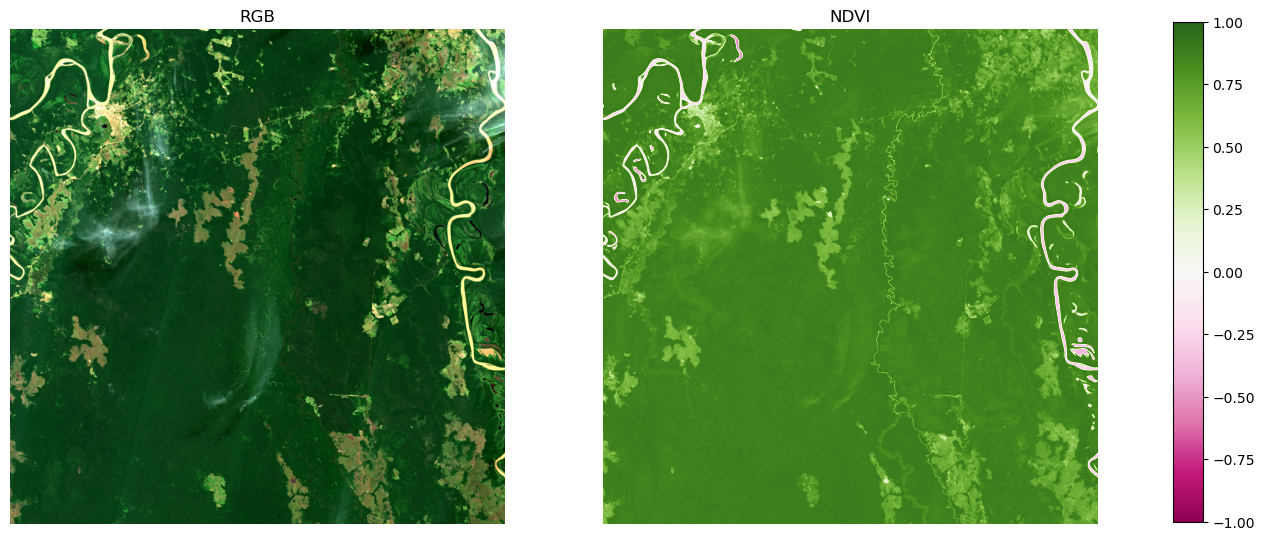

In [12]:
plot_rgb_vs_index(river_rgb, ndvi, index_name="ndvi")

# Normalized Burn Ratio 

The Normalized burn ratio (NBR) is used to identify burned areas. Usually, you need two images acquired at different times (before and after the fire). The formula is similar to NDVI, except that it uses near-infrared and shortwave-infrared bands.

NBR = (NIR - SWIR) / (NIR + SWIR)

Also here, we will exchange NIR (B08) by VNIR band 8a. Values below 0 indicate burned areas.

Further information: https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/vegetation-indices-in-python/. 

In [14]:
swir_band = river_patch["B11"]

nbr = calc_normalized_diff(vnir_band, swir_band)

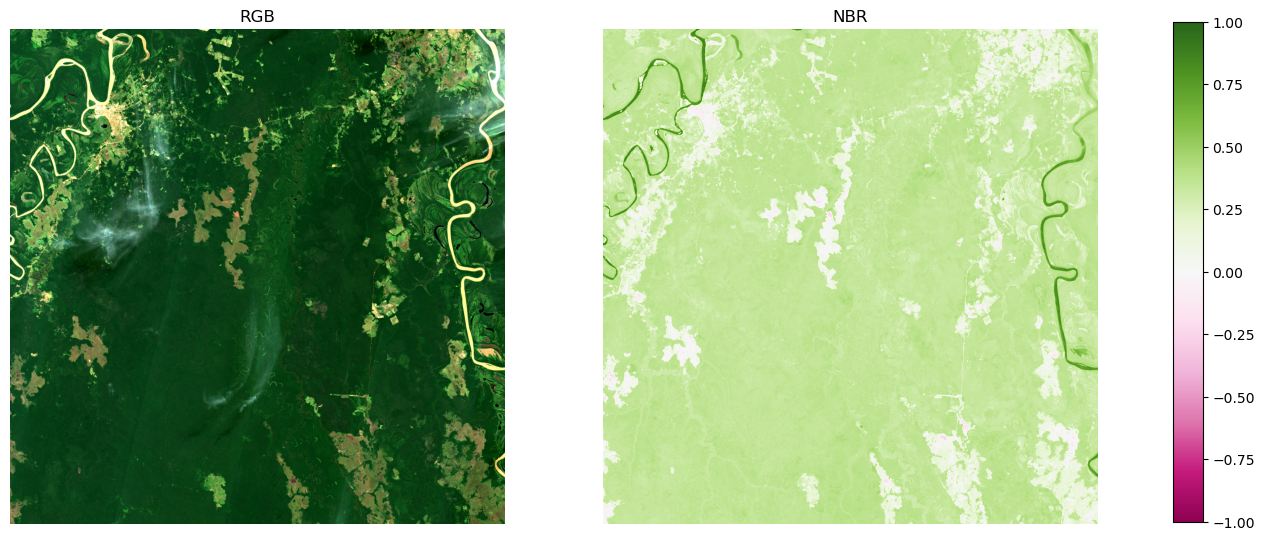

In [15]:
plot_rgb_vs_index(river_rgb, nbr, "nbr")

### A closer look actually reveals some burned areas in the amazon:

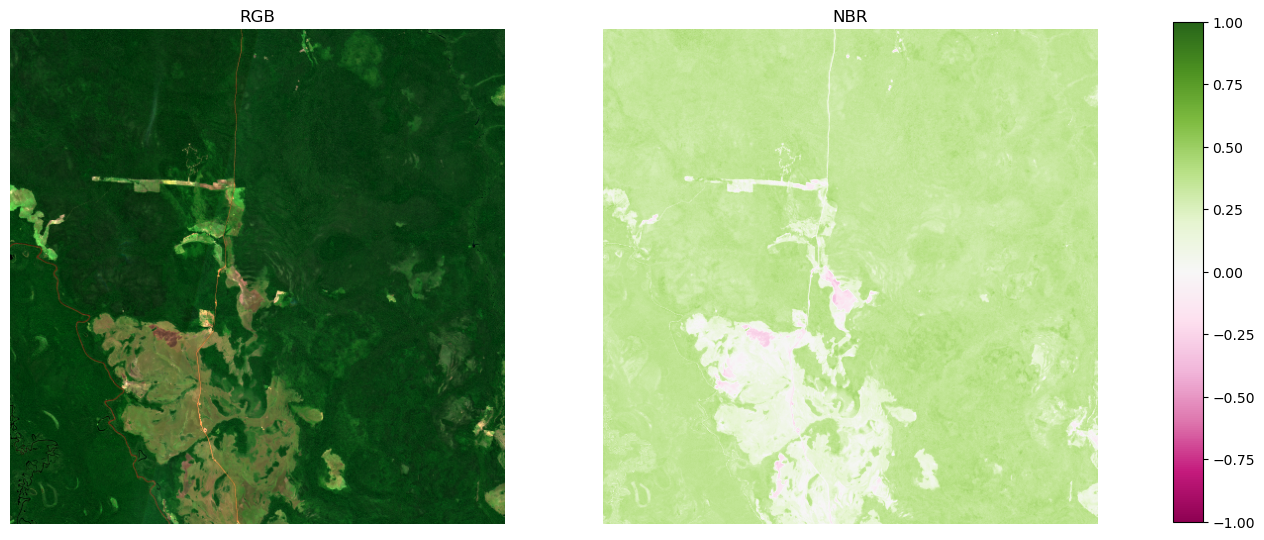

In [16]:
plot_rgb_vs_index(river_rgb[1200:1700, 1100:1600], nbr[1200:1700, 1100:1600], "nbr")

# In-course practice I (Normalized Difference Snow Index)

The Normalized Difference Snow Index (NDSI) is an index that shows the presence of snow in a pixel. The formula is similar to NDVI, and NBR except that it uses green and shortwave-infrared bands:

NDSI = (Green - SWIR) / (Green + SWIR)

The range between 0 and 1 can be associated with snow. Any value below 0 indicates the absence of snow.

**Task**: To do this practice, we select another patch which includes snow. The following cell will automatically download the patch. It is preprocessed in the same way as the river patch is. Compute the NDSI for the the snowpatch. Select and quantile-normalize the RGB channels for visualization purposes.

In [17]:
snow_patch_path = data_path / "snow_patch.npy"
snow_patch_path

PosixPath('data/snow_patch.npy')

In [18]:
download_file_with_progress(
    "https://tubcloud.tu-berlin.de/s/fmbBqbojf3GA7Em/download/lab05_snow_data.npz", snow_patch_path
)
snow_patch = np.load(snow_patch_path)
snow_patch.files

Output()

/tmp/ipykernel_1112/3593354870.py:17: TqdmExperimentalWarning: rich is experimental/alpha
  for data in tqdm(


['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B8A', 'B09', 'B11', 'B12']

In [25]:
channel_names = ["B04", "B03", "B02"]
snow_rgb = np.stack([snow_patch[b] for b in channel_names], axis=-1)
assert river_rgb.shape[-1] == 3

In [28]:
green_band = snow_patch["B03"]
swir_band = snow_patch["B11"]

snow_rgb = quant_norm_data(snow_rgb)
ndsi = calc_normalized_diff(green_band, swir_band) # all works?

/tmp/ipykernel_1112/1127609306.py:17: RuntimeWarning: invalid value encountered in divide
  n_diff = (b1 - b2) / (b1 + b2)


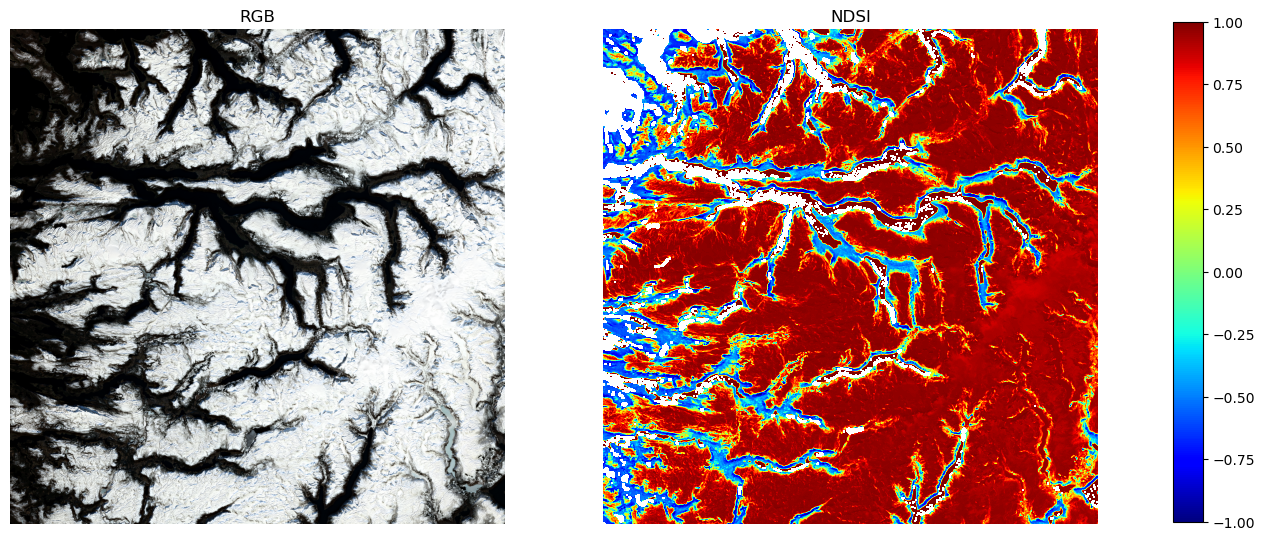

In [29]:
plot_rgb_vs_index(snow_rgb, ndsi, "ndsi")

# Part II: Pixel-Based Supervised Classification with K-Nearest Neighbors (KNN)

For this course we use the "IndianPines" hyperspectral image selected from Hyperspectral (HS) datasets that are publicly available at http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes.

## Define Dataset class

This notebook downloads the "IndianPines" hyperspectral image and its corresponding ground reference map (class labels assigned per pixel). 

- 200 bands
- 16 land cover classes, namely: 'Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill', 'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives', 'Stone-Steel-Towers'.

**Note:** that in the classification map some areas are not labeled ('Undefined') that have to be excluded.

Download also available via TUB-cloud: https://tubcloud.tu-berlin.de/s/oAdtGjHzTTJH7Xc/download/IndianPines.zip.

In [31]:
import zipfile
import scipy.io

In [32]:
class IndianPines():
    def __init__(self, base_dir: str):
    
        self.download_dataset(base_dir)
        self.datacube = self.normalize_img(self.open_datacube(base_dir))
        self.gt = self.open_gt(base_dir) # integer for class

        self.class_names = [
            "Undefined", # unrelated
            "Alfalfa",
            "Corn-notill",
            "Corn-mintill",
            "Corn",
            "Grass-pasture",
            "Grass-trees",
            "Grass-pasture-mowed",
            "Hay-windrowed",
            "Oats",
            "Soybean-notill",
            "Soybean-mintill",
            "Soybean-clean",
            "Wheat",
            "Woods",
            "Buildings-Grass-Trees-Drives",
            "Stone-Steel-Towers",
        ]
        self.ignored_labels = [0]
        self.rgb_bands = (31, 15, 11)
        self.num_bands = self.datacube.shape[-1]
        self.num_classes = len(self.class_names) # 17
    
    def download_dataset(self, base_dir: str):
        indian_pines_path = base_dir / "IndianPines.zip"
        download_file_with_progress(
            "https://tubcloud.tu-berlin.de/s/oAdtGjHzTTJH7Xc/download/IndianPines.zip",
            indian_pines_path,
        )
        zipf = zipfile.ZipFile(indian_pines_path)
        zipf.extractall(base_dir)
    
    def open_datacube(self, base_dir: str) -> np.array:
        image_path = base_dir /  "IndianPines/Indian_pines_corrected.mat"
        return scipy.io.loadmat(image_path)["indian_pines_corrected"]
    
    def open_gt(self, base_dir: str) -> np.array:
        gt_path = base_dir / "IndianPines/Indian_pines_gt.mat" # 2d map to specific class integer
        return scipy.io.loadmat(gt_path)["indian_pines_gt"]
    
    def normalize_img(self, img: np.array) -> np.array:
        img = np.asarray(img, dtype="float32")
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        return img

In [36]:
# CLASSES
indian_pines = IndianPines(data_path)

Output()

/tmp/ipykernel_1112/3593354870.py:17: TqdmExperimentalWarning: rich is experimental/alpha
  for data in tqdm(


In [37]:
indian_pines.datacube.shape

(145, 145, 200)

In [38]:
indian_pines.num_classes

17

## Visualization of the Image and Land Cover Map (Classification Map)

In [39]:
import matplotlib
import spectral

In [40]:
# create handles for legend
cmap = matplotlib.colormaps.get_cmap("tab20") # 20 predefined colors
handles = [matplotlib.patches.Patch(color=cmap(i), label=indian_pines.class_names[i]) for i in range(17)] # colormap

In [41]:
def adjust_cmap(segmentation_map:np.array, cmap_name: str) -> matplotlib.colors.ListedColormap:
    "Adjust color pallette according to classes present in segmentation map."
    cmap = matplotlib.colormaps.get_cmap(cmap_name)
    colors = cmap(np.linspace(0, 1, cmap.N))
    adj_colors = colors[:np.max(segmentation_map) + 1]
    return matplotlib.colors.ListedColormap(adj_colors)

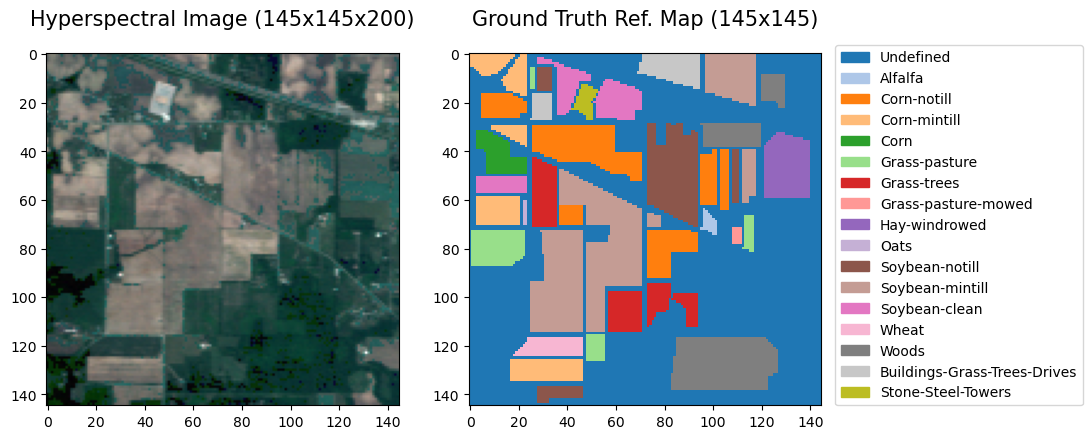

In [42]:
datacube_rgb = spectral.get_rgb(indian_pines.datacube, bands=indian_pines.rgb_bands)

fig, axes = plt.subplots(1, 2, figsize=(10, 7))
axes[0].set_title(
    "Hyperspectral Image ({}x{}x{})".format(*indian_pines.datacube.shape), fontsize=15, pad=20
)
axes[0].imshow(datacube_rgb)
axes[1].set_title("Ground Truth Ref. Map ({}x{})".format(*indian_pines.gt.shape), fontsize=15, pad=20)
axes[1].imshow(indian_pines.gt, cmap=adjust_cmap(indian_pines.gt, "tab20"), interpolation="none")
axes[1].legend(handles=handles, loc=(1.04, 0))
plt.show()

## Creating Train and Test sets

We need to create two sets for train and test purposes.

In the pixel-based classification each set (test/train) includes a certain number of samples. Each sample represents a pixel with its spectral values and its assigned class label. For the IndianPines dataset each sample consists of 200 spectral band values and one label (between 0-16).

In [43]:
def sample_gt(gt: np.array, train_percentage: float) -> (np.array, np.array):
    """
    Extract a fixed percentage of samples from an 2d-array of labels.

    Parameter
    ---------
    gt                : a 2D array of int labels
    train_percentage  : [0, 1] float

    Return
    ------
    train_gt, test_gt : 2D arrays of int labels

    """
    train_gt, test_gt = gt.copy(), gt.copy()

    for c in np.unique(gt):
        mask = gt == c
        for x in range(gt.shape[0]):
            first_half_count = np.count_nonzero(mask[:x, :])
            if first_half_count / np.count_nonzero(mask) > train_percentage:
                break

        train_mask = mask.copy()
        train_mask[:x, :] = 0
        train_gt[train_mask] = 0

        test_mask = mask.copy()
        test_mask[x:, :] = 0
        test_gt[test_mask] = 0

    return train_gt, test_gt

In [44]:
train_gt, test_gt = sample_gt(indian_pines.gt, 0.8)
# adjacent or randomly -> reduce correlation, incline to spatial neighborhood
n_train = np.count_nonzero(train_gt)
n_test = np.count_nonzero(test_gt)
n_total = np.count_nonzero(indian_pines.gt)

print("Train:  {} samples selected (over {})".format(n_train, n_total))
print("Test:   {} samples selected (over {})".format(n_test, n_total))

Train:  8337 samples selected (over 10249)
Test:   1912 samples selected (over 10249)


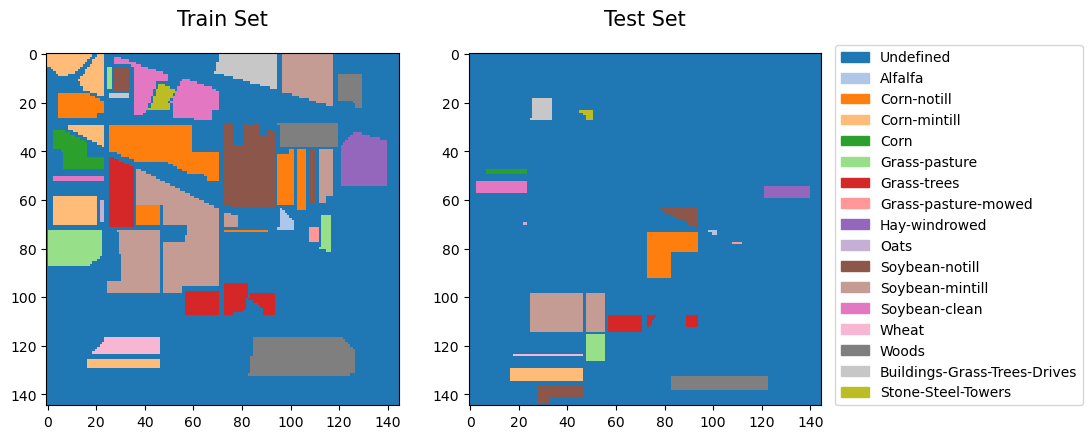

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
axes[0].set_title("Train Set", fontsize=15, pad=20)
axes[0].imshow(train_gt, cmap=adjust_cmap(indian_pines.gt, "tab20"), interpolation="none")
axes[1].set_title("Test Set", fontsize=15, pad=20)
axes[1].imshow(test_gt, cmap=adjust_cmap(indian_pines.gt, "tab20"), interpolation="none")
axes[1].legend(handles=handles, loc=(1.04, 0))
plt.show()

In [46]:
from typing import List

In [47]:
def create_pixel_classification_dataset(
    hypercube: np.array, gt: np.array, ignored_labels: List[int] = []
) -> (np.array, np.array):
    """Based on ground truth reference map, divide hypercube into individual hyperspectral pixel datapoints."""
    """ labelling """
    assert hypercube.shape[:2] == gt.shape[:2]  # spatial dimension of hypercube and ground truth equal?
    X, y = [], []
    classes = set(np.unique(gt)) - set(ignored_labels) # - no crips type

    for cl in classes:
        # cl_indices is a tuple of two np.array, one for the x and and one for y coordinate
        cl_indices = np.nonzero(gt == cl)
        X += list(hypercube[cl_indices])
        y += len(cl_indices[0]) * [cl]

    # shuffle data
    xy_zipped = list(zip(X, y))
    np.random.shuffle(xy_zipped)
    X, y = zip(*xy_zipped)

    return np.asarray(X), np.asarray(y)

In [48]:
# create training data
X_train, y_train = create_pixel_classification_dataset(
    indian_pines.datacube,
    train_gt,
    indian_pines.ignored_labels
)

# create testing data
X_test, y_test = create_pixel_classification_dataset(
    indian_pines.datacube,
    test_gt,
    indian_pines.ignored_labels
)

## In-course practice II

Plot spectral signature of 3 different classes. These are the features that we use for classification.
You can select one single sample or calculate the average of samples for each class from train samples.

In [62]:
# to know how to distinguish
corn_idx = np.array(np.where(y_train == 4))[-1]
corn_spectral_sig = X_train[corn_idx,:].mean(axis=0)

oat_idx = np.array(np.where(y_train == 9))[-1]
oat_spectral_sig = X_train[oat_idx,:].mean(axis=0)

woods_idx = np.array(np.where(y_train == 14))[-1]
woods_spectral_sig = X_train[woods_idx,:].mean(axis=0)

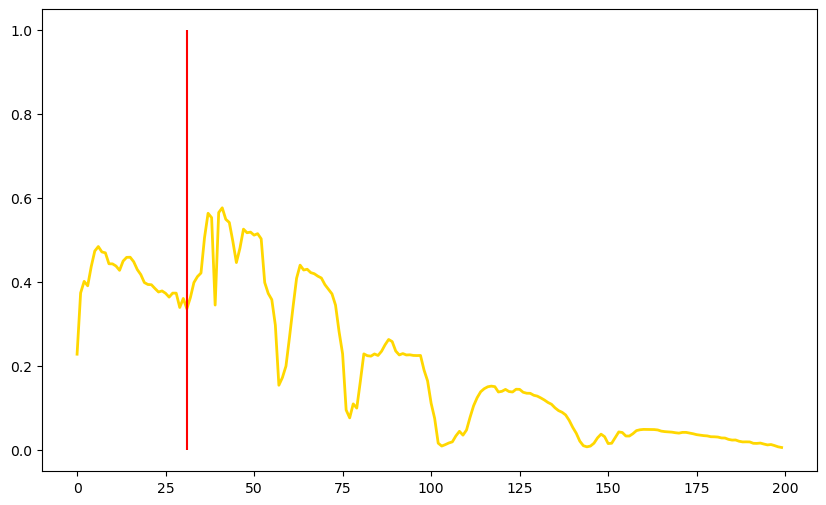

In [52]:
plt.figure(figsize=(10,6))
plt.plot(corn_spectral_sig, label="corn", linewidth=2, color="gold")
plt.plot(oat_spectral_sig, label="corn", linewidth=2, color="gold")
plt.plot(corn_spectral_sig, label="corn", linewidth=2, color="gold")
plt.vlines(31,0,1,color='r')

## Training a KNN Classifer

k-Nearest Neighbor is a supervised algorithm, which is usually used for classification tasks. It measures the distances between the training samples (shown by circles in the figure) and unseen test data (is shown by *star* in the figure) and makes the prediction (class label) accordingly.

<img src="https://miro.medium.com/max/1400/1*2zYNhLc522h0zftD1zDh2g.png" align="left" alt="Drawing" style="width: 500px;"/>
    
    
    
    
credit: medium.com/@equipintelligence

In [53]:
from sklearn.neighbors import KNeighborsClassifier

In [54]:
# initialize knn model with n_neighbors
knn = KNeighborsClassifier(n_neighbors=1)

# fit (train) the knn model with our trainings data
knn.fit(X_train, y_train)

# predict on test data
y_pred = knn.predict(X_test)

## Evaluating a trained KNN Classifier

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/400px-Precisionrecall.svg.png" align="right" alt="Drawing" style="width: 400px;"/>


<br> <br>
 
<font size="4"> <ins> **Evaluation Metrics** </ins> </font>
 

<font size="4"> TP = classified correctly as True (sample belongs to class)  </font>

<font size="4"> TN = classified correctly as False (sample belongs not to class)  </font>

<font size="4"> FP = classified incorrectly as True (sample belongs not to class)  </font>

<font size="4"> FN = classified incorrectly as False (sample belongs to class)  </font>

<font size="4"> N = TP + TN + FP + FN  </font>

<font size="4"> Accuracy = (TP + TN) / N  </font>

<font size="4"> Precision = TP / (TP + FP)  </font>

<font size="4"> Recall = TP (TP + FN)  </font>

<font size="4"> F1-Score = 2 x (Precision x Recall) / (Precision + Recall)  </font>

## Accuracy

In [55]:
acc = np.count_nonzero(y_pred == y_test) / len(y_pred)
print("Accuracy for k=1: {:.2f}".format(acc))

Accuracy for k=1: 0.60


## Class-wise Metrics

In [56]:
from sklearn.metrics import classification_report

In [57]:
active_cl_ints = [i for i in range(len(indian_pines.class_names)) if not i in indian_pines.ignored_labels]
active_cl_names = [indian_pines.class_names[i] for i in active_cl_ints]

In [58]:
report = classification_report(y_test, y_pred, target_names=active_cl_names)
print(report)

                              precision    recall  f1-score   support

                     Alfalfa       0.36      0.67      0.47         6
                 Corn-notill       0.48      0.36      0.41       278
                Corn-mintill       0.14      0.17      0.15       150
                        Corn       0.17      0.56      0.26        34
               Grass-pasture       0.47      0.16      0.24        88
                 Grass-trees       0.82      0.83      0.83       135
         Grass-pasture-mowed       0.67      1.00      0.80         4
               Hay-windrowed       0.82      0.93      0.87        95
                        Oats       0.25      0.50      0.33         2
              Soybean-notill       0.62      0.44      0.51       177
             Soybean-mintill       0.67      0.76      0.72       480
               Soybean-clean       0.51      0.45      0.48       105
                       Wheat       0.79      0.93      0.86        29
                   

## Confusion Matrix Visualization

In [59]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [60]:
conf_mat = confusion_matrix(y_test, y_pred)

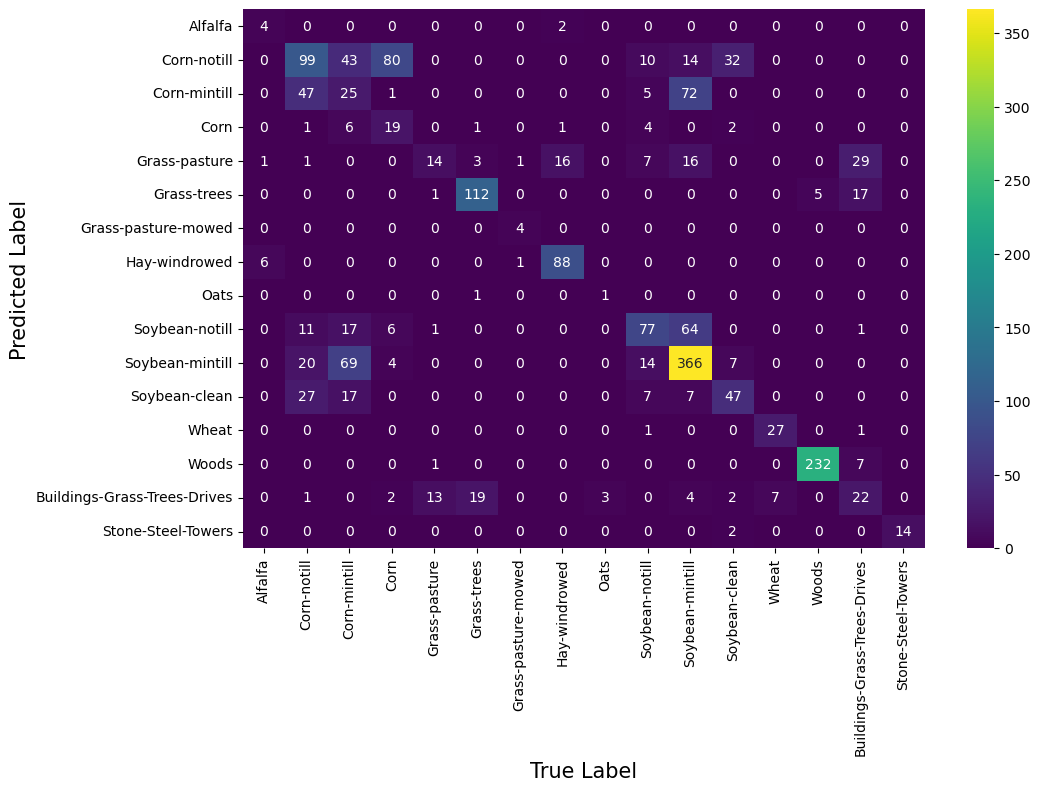

In [61]:
plt.subplots(1, 1, figsize=(11, 7))
sns.heatmap(
    conf_mat,
    cmap="viridis",
    fmt="d",
    xticklabels=active_cl_names,
    yticklabels=active_cl_names,
    annot=True,
)
plt.xlabel("True Label", fontsize=15)
plt.ylabel("Predicted Label", fontsize=15)
plt.show()

## In-course practice III

* Reduce the number of training samples into 2% and observe how the accuracy changes

* Instead of 1-NN, use 3-NN and 7-NN for KNN classifier and observe how the accuracy changes.

In [75]:
train_gt, test_gt = sample_gt(indian_pines.gt, 0.8)
# adjacent or randomly -> reduce correlation, incline to spatial neighborhood
n_train = np.count_nonzero(train_gt)
n_test = np.count_nonzero(test_gt)
n_total = np.count_nonzero(indian_pines.gt)

print("Train:  {} samples selected (over {})".format(n_train, n_total))
print("Test:   {} samples selected (over {})".format(n_test, n_total))

Train:  8337 samples selected (over 10249)
Test:   1912 samples selected (over 10249)


In [76]:
# create training data
X_train, y_train = create_pixel_classification_dataset(
    indian_pines.datacube,
    train_gt,
    indian_pines.ignored_labels
)

# create testing data
X_test, y_test = create_pixel_classification_dataset(
    indian_pines.datacube,
    test_gt,
    indian_pines.ignored_labels
)

In [77]:
# initialize knn model with n_neighbors
for i in [1, 3, 7, 16]:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train[:100], y_train[:100])
    y_pred = knn.predict(X_test)
    
    acc = np.count_nonzero(y_pred == y_test) / len(y_pred)
    print("Accuracy for k={}: {:.2f}".format(i, acc))

Accuracy for k=1: 0.43
Accuracy for k=3: 0.50
Accuracy for k=7: 0.46
Accuracy for k=16: 0.41
